# Notebook 02: Análisis Exploratorio de Datos (EDA) y Detección de Shocks
**Proyecto:** Análisis SARIMAX - Starbucks Corporation (SBUX)  
**Investigador:** Frankli Zeña Zeña (UNI)

---
## Introducción
En este cuaderno realizaremos un análisis estadístico profundo de la serie de tiempo de Starbucks. Nos enfocaremos en identificar los momentos de mayor volatilidad mediante el análisis de volumen, lo cual nos permitirá correlacionar datos cuantitativos con eventos cualitativos (noticias).

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [13]:
# Configuración de estilo para el informe
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# Carga de datos procesados en el Notebook 01
df = pd.read_csv('../data/processed/SBUX_clean.csv', index_col=0, parse_dates=True)

print(f"Datos cargados correctamente. Rango: {df.index.min()} a {df.index.max()}")
df

Datos cargados correctamente. Rango: 2021-03-15 00:00:00 a 2026-02-13 00:00:00


,Adj Close,Volume,Vol_Avg_20,Vol_Anomaly,Log_Return
Date,,,,,
2021-03-15,97.091217,7107300,6295740.0,False,0.010060
2021-03-16,99.266632,11376200,6618145.0,False,0.022159
2021-03-17,98.482056,10128400,6837875.0,False,-0.007935
2021-03-18,95.950020,7813400,7023610.0,False,-0.026047
2021-03-19,94.808807,21452000,7889765.0,True,-0.011965
...,...,...,...,...,...
2026-02-09,98.345779,7150600,11434955.0,False,-0.004737
2026-02-10,96.905067,8543500,11497655.0,False,-0.014758
2026-02-11,98.484879,6949100,11567015.0,False,0.016171


### 1. Estadísticas Descriptivas
Calculamos las métricas fundamentales para entender la distribución de los precios y los retornos logarítmicos. La **curtosis** alta nos indicará la presencia de valores atípicos (shocks de mercado).

--- Resumen Estadístico de Retornos ---
count    1237.000000
mean       -0.000020
std         0.019517
min        -0.172896
25%        -0.009325
50%        -0.000086
75%         0.009154
max         0.219111
Name: Log_Return, dtype: float64

Curtosis: 21.0012 (Valores > 3 indican colas pesadas/shocks)
Sesgo: 0.6574


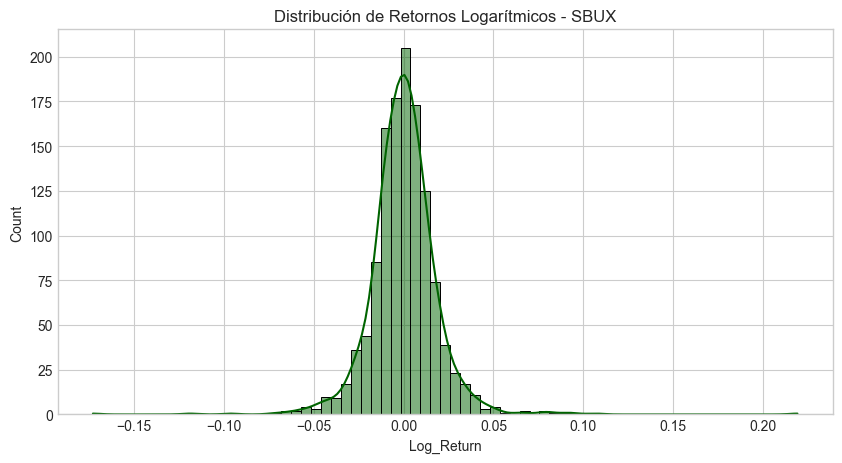

In [14]:
# Cálculo de métricas sobre Retornos Logarítmicos
stats = df['Log_Return'].describe()
kurt = df['Log_Return'].kurt()
skew = df['Log_Return'].skew()

print("--- Resumen Estadístico de Retornos ---")
print(stats)
print(f"\nCurtosis: {kurt:.4f} (Valores > 3 indican colas pesadas/shocks)")
print(f"Sesgo: {skew:.4f}")

# Histograma de retornos para ver la "normalidad"
plt.figure(figsize=(10, 5))
sns.histplot(df['Log_Return'], kde=True, color='darkgreen')
plt.title('Distribución de Retornos Logarítmicos - SBUX')
plt.show()

### 2. Identificación de Anomalías de Volumen
Filtramos los días donde el volumen operado superó el doble de su media móvil de 20 días. Estos puntos representan momentos de alta convicción en el mercado, usualmente vinculados a noticias institucionales.

In [15]:
# Filtrar los registros donde Vol_Anomaly es True
anomalies_list = df[df['Vol_Anomaly'] == True].copy()
anomalies_list[['Adj Close', 'Volume', 'Log_Return']]

,Adj Close,Volume,Log_Return
Date,,,
2021-03-19,94.808807,21452000,-0.011965
2021-04-28,100.211693,14793500,-0.032818
2021-06-25,101.183266,12171200,0.009332
2021-09-15,103.013725,11556200,-0.036150
2021-10-29,95.312874,27419600,-0.065057
2021-11-01,98.664597,14184600,0.034561
2022-01-20,86.383369,20311500,-0.011943
2022-03-16,79.283936,21207900,0.050324
2022-03-18,81.270325,23784200,0.021889


#### 2.1. Visualización de Shocks vs Precio
Superponemos las anomalías detectadas sobre la serie de precios. Este gráfico es fundamental para el informe final, ya que justifica visualmente la necesidad de un modelo que considere la volatilidad.

In [16]:
import plotly.graph_objects as go

In [17]:
fig = go.Figure()

# 1. Trazar el precio base
fig.add_trace(go.Scatter(
    x=df.index, 
    y=df['Adj Close'],
    mode="lines", 
    name="Precio SBUX",
    line=dict(color="green", width=1) # Verde tenue
))

# 2. Resaltar Anomalías (Puntos Rojos)
anomalies = df[df['Vol_Anomaly'] == True]

fig.add_trace(go.Scatter(
    x=anomalies.index, 
    y=anomalies['Adj Close'],
    mode="markers", 
    name="Anomalía de Volumen",
    marker=dict(color="red", size=8, symbol="circle"),
    # Texto que aparecerá al pasar el cursor
    text=[f"Volumen: {v:,.0f}" for v in anomalies['Volume']],
    hovertemplate="<b>Fecha:</b> %{x}<br><b>Precio:</b> $%{y:.2f}<br>%{text}<extra></extra>"
))

fig.update_layout(
    title="Detección Interactiva de Shocks Externos (Picos de Volumen)",
    xaxis_title="Fecha",
    yaxis_title="Precio (USD)",
    hovermode="closest",
    template="plotly_white",
    width=1200, 
    height=600
)

fig.show()

#### 2.2. Herramienta de Investigación de Noticias
Para completar el archivo `news_history.csv`, utilizaremos los links generados a continuación para identificar qué evento ocurrió en las fechas de mayor anomalía.

In [18]:
import webbrowser

In [19]:
print("--- BUSCADOR DE NOTICIAS HISTÓRICAS ---")

for date in anomalies_list.index:
    d_str = date.strftime('%Y-%m-%d') #Formato (YYYY-MM-DD)
    search_url = f"https://www.google.com/search?q=Starbucks+news+{d_str}&tbm=nws"
    
    print(f"Fecha: {d_str} | Buscar: {search_url}")

--- BUSCADOR DE NOTICIAS HISTÓRICAS ---
Fecha: 2021-03-19 | Buscar: https://www.google.com/search?q=Starbucks+news+2021-03-19&tbm=nws
Fecha: 2021-04-28 | Buscar: https://www.google.com/search?q=Starbucks+news+2021-04-28&tbm=nws
Fecha: 2021-06-25 | Buscar: https://www.google.com/search?q=Starbucks+news+2021-06-25&tbm=nws
Fecha: 2021-09-15 | Buscar: https://www.google.com/search?q=Starbucks+news+2021-09-15&tbm=nws
Fecha: 2021-10-29 | Buscar: https://www.google.com/search?q=Starbucks+news+2021-10-29&tbm=nws
Fecha: 2021-11-01 | Buscar: https://www.google.com/search?q=Starbucks+news+2021-11-01&tbm=nws
Fecha: 2022-01-20 | Buscar: https://www.google.com/search?q=Starbucks+news+2022-01-20&tbm=nws
Fecha: 2022-03-16 | Buscar: https://www.google.com/search?q=Starbucks+news+2022-03-16&tbm=nws
Fecha: 2022-03-18 | Buscar: https://www.google.com/search?q=Starbucks+news+2022-03-18&tbm=nws
Fecha: 2022-05-04 | Buscar: https://www.google.com/search?q=Starbucks+news+2022-05-04&tbm=nws
Fecha: 2022-08-03 | 

In [20]:
# Cargar registro de noticias (asegúrate de haberlo creado en la carpeta data/external/)
news = pd.read_csv('../data/external/news_history.csv', index_col=0, parse_dates=True)
news


,Evento,Categoria,Efecto,Fuente,Impacto_Neto
Fecha,,,,,
2021-03-16,Luckin reestructuración deuda,Competencia,negativo,https://investor.luckincoffee.com/news-release...,competencia_global
2021-03-17,50th Anniversary Blend Starbucks,Fundamental,positivo,https://www.gcrmag.com/starbucks-celebrates-it...,evento_marca
2021-03-18,Expansión pickup Dunkin,Competencia,negativo,https://news.dunkindonuts.com/news/dunkin-joy-...,competencia_qsr
2021-03-19,Costa Express inteligente,Competencia,negativo,https://caternewsdigital.com/internacional/cos...,competencia_qsr
2021-03-20,McCafe integrado en app,Competencia,negativo,https://www.infofranquicias.com/fd-1348/franqu...,competencia_precio
2021-04-28,Resultados Q2 FY21,Earnings,positivo,https://investor.starbucks.com/news/financial-...,earnings
2021-06-25,Escasez insumos,Demand,negativo,https://www.businessinsider.com/starbucks-shor...,shock_operativo
2021-09-15,Aumento dividendo,Dividendos,positivo,https://www.nasdaq.com/articles/starbucks-sbux...,politica_accionista
2021-10-29,Subida salarial partners,Costos,negativo,https://www.cnbc.com/2021/10/27/starbucks-to-r...,shock_costos


In [21]:
# 1. Preparar df_anomalies
df_anomalies = df[df['Vol_Anomaly'] == True].reset_index()
# Si Yahoo Finance bajó los datos como 'Date', lo renombramos a 'Fecha'
if 'Date' in df_anomalies.columns:
    df_anomalies = df_anomalies.rename(columns={'Date': 'Fecha'})

# 2. Preparar news
# Aseguramos que news tenga la columna 'Fecha' disponible para el merge
df_news_to_merge = news.reset_index()
if 'index' in df_news_to_merge.columns: # Por si acaso reset_index le puso 'index'
    df_news_to_merge = df_news_to_merge.rename(columns={'index': 'Fecha'})

# 3. Realizar el merge ahora que estamos SEGUROS de que existe 'Fecha' en ambos
df_combined = pd.merge(df_anomalies, df_news_to_merge, on='Fecha', how='left')

# 4. Limpieza de nulos para el gráfico
df_combined['Evento'] = df_combined['Evento'].fillna("Sin evento registrado")
df_combined['Categoria'] = df_combined['Categoria'].fillna("N/A")

# --- De aquí en adelante el código del gráfico es el mismo ---
fig = go.Figure()

# Traza 1: Precio Base
fig.add_trace(go.Scatter(
    x=df.index, y=df['Adj Close'],
    mode="lines", name="Precio SBUX",
    line=dict(color="rgba(0, 112, 74, 0.2)", width=1.5),
    hoverinfo='skip'
))

# Traza 2: Anomalías
fig.add_trace(go.Scatter(
    x=df_combined['Fecha'], 
    y=df_combined['Adj Close'],
    mode="markers", name="Shock Detectado",
    marker=dict(color="red", size=10, symbol="diamond", line=dict(width=1, color="black")),
    text=df_combined['Evento'],
    customdata=np.stack((df_combined['Categoria'], df_combined['Volume']), axis=-1),
    hovertemplate="""
    <b>Fecha:</b> %{x|%d %b %Y}<br>
    <b>Precio:</b> $%{y:.2f}<br>
    <b>Volumen:</b> %{customdata[1]:,.0f}<br>
    <br>
    <b>Evento:</b> %{text}<br>
    <b>Categoría:</b> %{customdata[0]}
    <extra></extra>
    """
))

fig.update_layout(
    title="<b>Análisis de Shocks en Starbucks: Correlación Precio-Evento</b>",
    template="plotly_white", xaxis_title="Eje Temporal", yaxis_title="Precio (USD)",
    width=1300, height=650, xaxis=dict(rangeslider=dict(visible=True))
)

fig.show()

### 3. Integración de Análisis Fundamental (Estados Financieros)
El objetivo es capturar la salud económica de la empresa (Ventas y Márgenes) para justificar los movimientos del precio y generar variables de control para nuestro futuro modelo SARIMAX.

**Pasos a realizar:**
1. Descarga del Estado de Resultados Trimestral (Income Statement).
2. Limpieza y cálculo de ratios clave ($Margen\ Operativo = \frac{Ingreso\ Operativo}{Ventas\ Totales}$).
3. Fusión (Merge) con nuestra serie de tiempo principal usando un "Forward Fill" para que el mercado "recuerde" el último reporte trimestral en sus operaciones diarias.

In [22]:
import yfinance as yf

ticker = yf.Ticker("SBUX")
df_q = ticker.quarterly_financials  # trimestral
df_q = df_q.loc[["Total Revenue", "Operating Income", "Net Income"]]
df_q = df_q.T
df_q


,Total Revenue,Operating Income,Net Income
2025-12-31,9.915100e+09,9.183000e+08,293300000.0
2025-09-30,9.569000e+09,9.481000e+08,133200000.0
2025-06-30,9.456000e+09,8.993000e+08,558300000.0
2025-03-31,8.761600e+09,6.581000e+08,384200000.0
2024-12-31,9.397800e+09,1.075200e+09,780800000.0
2024-09-30,NaN,NaN,NaN
2024-06-30,NaN,NaN,NaN


> Dado que de `yfinance` solo obtenemos unos pocos últimos trimestres, utilizaremos otra librería para obtener los datos que necesitamos

In [23]:
# %pip install stockdex
from stockdex import Ticker

In [24]:
#Cargamos el Ticker y las funciones del Income Statement trimestral
ticker = Ticker("SBUX")
help(ticker.macrotrends_income_statement)

Help on method macrotrends_income_statement in module stockdex.macrotrends_interface:

macrotrends_income_statement(
    frequency: Literal['quarterly', 'annual'] = 'annual'
) -> pd.DataFrame method of stockdex.ticker.Ticker instance
    Retrieve the income statement for the given ticker.



In [25]:
# 1. Descargamos el Income Statement trimestral y filtramos las métricas que nos interesan
income_q = ticker.macrotrends_income_statement(frequency="quarterly")
df_metrics = income_q.loc[["Revenue", "Operating Income", "Net Income"]]

# 2. Para filtrar años 2021–2025, filtramos columnas
cols_to_keep = [c for c in df_metrics.columns if c.startswith(("2020", "2021", "2022", "2023", "2024", "2025"))]
df_financials = df_metrics[cols_to_keep].T

# 3. Limpiamos y convertimos a float
df_financials = df_financials.astype(float)  # convierte a float

# 4. Guardamos la data cruda
os.makedirs('../data/raw', exist_ok=True)
finantials_path = '../data/raw/sbux_financials_raw.csv'
df_financials.to_csv(finantials_path)
print(f"Archivo crudo guardado en {finantials_path}")

df_financials

Archivo crudo guardado en ../data/raw/sbux_financials_raw.csv


field_name,Revenue,Operating Income,Net Income
2025-12-31,9915.100,890.7998,293.3000
2025-09-30,9568.999,278.2979,133.1001
2025-06-30,9456.000,935.5996,558.3000
2025-03-31,8761.600,600.9995,384.2000
2024-12-31,9397.800,1121.7000,780.8000
2024-09-30,9073.999,1307.0010,909.2998
2024-06-30,9113.900,1517.5000,1054.8000
2024-03-31,8563.000,1098.9000,772.4000
2023-12-31,9425.300,1485.3990,1024.4000
2023-09-30,9373.600,1706.3010,1219.3000


``Análisis Financiero (Últimos 5 Años) ...``

> ##### Ingresos (Revenue)
> 
> **Tendencia general: crecimiento estructural.**
> 
> - **2020:** fuerte impacto en Q2 2020 (caída a ~4,222) por pandemia.
> - **2021–2023:** recuperación sólida y crecimiento sostenido.
> - **2024–2025:** ingresos más estables, alrededor de 9,000–9,900 por trimestre.
> 
> **En 5 años:**
> 
> - Pasó de niveles de ~6,000–7,000 por trimestre  
> - A niveles cercanos a 9,500–10,000  
> 
> Crecimiento claro post-COVID  
> Estabilización reciente (ya no crece tan aceleradamente)  

> #### Utilidad Operativa (Operating Income)
> 
> Aquí vemos más volatilidad:
> 
> - **2020 Q2:** pérdida operativa (-703)  
> - Recuperación fuerte en **2021–2023** (picos de 1,500–1,700)  
> - En **2025** vemos cierta desaceleración comparado con los máximos 2023–2024  
> 
> El margen operativo mejoró mucho después de pandemia, pero en 2025 parece comprimirse ligeramente.

> #### Utilidad Neta (Net Income)
> 
> - **2020:** muy afectada (incluso negativa en Q2 2020)  
> - **2021–2023:** recuperación muy fuerte  
> - **2023:** trimestres arriba de 1,100–1,200  
> - **2024–2025:** sigue positiva pero con algo más de variabilidad  
> 
> La empresa volvió a niveles sólidos de rentabilidad, aunque 2025 no luce tan fuerte como el pico 2023.

> #### Resumen por etapas
> 
> ##### 2020 – Impacto COVID
> 
> - Fuerte caída en ingresos  
> - Pérdidas operativas  
> - Alta volatilidad  
> 
> ##### 2021–2023 – Recuperación y expansión
> 
> - Crecimiento constante  
> - Mejora de márgenes  
> - Utilidades en máximos  
> 
> ##### 2024–2025 – Estabilización
> 
> - Ingresos altos pero crecimiento más lento  
> - Márgenes algo más presionados  
> - Rentabilidad estable pero no en máximos históricos

> #### Conclusión general
> 
> En los últimos 5 años Starbucks muestra:
> 
> - Recuperación exitosa post-pandemia  
> - Crecimiento estructural en ingresos  
> - Rentabilidad sólida  
> * Señales recientes de desaceleración en márgenes  

### 3.1. Limpieza e Ingeniería de Características Financieras
`yfinance` nos devuelve muchas cuentas contables. Para nuestro modelo, nos centraremos en los "drivers" principales que mueven la acción:
* **Revenue (Ventas Totales):** Indica si la empresa vende más o menos café.
* **Operating Income (Ingreso Operativo):** Lo que queda tras pagar costos directos (café, salarios).
* **Margen Operativo:** Nuestra nueva característica (Feature). Nos dirá la eficiencia real de la empresa.

In [26]:
# Preparamos la data
df_income = df_financials.copy()

# Aseguramos que el índice sea formato Datetime sin zona hozraria (para evitar problemas al cruzar)
df_income.index = pd.to_datetime(df_income.index).tz_localize(None)
df_income = df_income.sort_index()

# Calculamos el Ratio Financiero Clave
df_income['Margen_Operativo'] = df_income['Operating Income'] / df_income['Revenue']
df_income['Margen_Operativo_%'] = df_income['Margen_Operativo'] * 100

# Guardamos la versión limpia
processed_path = '../data/processed/sbux_financials_clean.csv'
df_income.to_csv(processed_path)
print(f"\nArchivo limpio y calculado guardado como '{processed_path}'")
df_income


Archivo limpio y calculado guardado como '../data/processed/sbux_financials_clean.csv'


field_name,Revenue,Operating Income,Net Income,Margen_Operativo,Margen_Operativo_%
2020-03-31,5995.700,487.4004,328.4000,0.081292,8.129166
2020-06-30,4222.100,-703.8999,-678.4000,-0.166718,-16.671796
2020-09-30,6203.100,558.3989,392.5999,0.090019,9.001933
2020-12-31,6749.400,913.4995,622.2000,0.135345,13.534529
2021-03-31,6668.000,987.6001,659.4000,0.148110,14.811039
2021-06-30,7496.500,1488.7000,1153.4000,0.198586,19.858601
2021-09-30,8146.700,1482.3010,1764.3000,0.181951,18.195110
2021-12-31,8050.400,1177.8000,815.9000,0.146303,14.630329
2022-03-31,7635.600,948.8999,674.5000,0.124273,12.427313
2022-06-30,8150.100,1295.5000,912.9000,0.158955,15.895510


> Observemos la columna ``Margen_Operativo_%``.  
> Se muestra que a inicios de 2024 (cerca de la crisis que vimos en la gráfica) este margen cae por debajo del 14%, esto es, desplome del precio de la acción esta justificado por una pérdida real de eficiencia, no solo por "pánico de mercado".

#### 3.2. Fusión de Datos y Creación de Variables Dummy (SARIMAX)
Ahora vamos a integrar todo. Tomaremos nuestro DataFrame principal (precios y volumen), le pegaremos los datos financieros trimestrales (rellenando los vacíos diarios) y usaremos nuestro archivo `news_history.csv` para crear las **Variables de Intervención (Dummies)**.

* **Dummy de Pulso (Pulse):** Un "1" solo en el día del evento (Ej. Publicación de un reporte). Mide shocks a corto plazo.
* **Dummy de Escalón (Step):** Un "1" a partir del día del evento en adelante (Ej. El cambio de CEO a Brian Niccol). Mide cambios estructurales.

``Cruzamos Estados Financieros...``

In [27]:
df_master = df.join(df_income[['Margen_Operativo_%', 'Revenue']], how='left')
df_master['Margen_Operativo_%'] = df_master['Margen_Operativo_%'].ffill()
df_master['Revenue'] = df_master['Revenue'].ffill()
#ahora eliminamos los registros que tengan alguna columna financiera nula (antes de cruzar con noticias)
df_master = df_master.dropna(subset=['Margen_Operativo_%', 'Revenue'])

df_master['Fecha'] = pd.to_datetime(df_master.index)
df_master

,Adj Close,Volume,Vol_Avg_20,Vol_Anomaly,Log_Return,Margen_Operativo_%,Revenue,Fecha
Date,,,,,,,,
2021-03-31,97.421112,6478400,7244615.0,False,-0.009110,14.811039,6668.0,2021-03-31
2021-04-01,97.519173,5793000,7173675.0,False,0.001006,14.811039,6668.0,2021-04-01
2021-04-05,98.981331,6913100,7241335.0,False,0.014882,14.811039,6668.0,2021-04-05
2021-04-06,100.880363,6745200,7322620.0,False,0.019004,14.811039,6668.0,2021-04-06
2021-04-07,100.916023,5629600,7328555.0,False,0.000353,14.811039,6668.0,2021-04-07
...,...,...,...,...,...,...,...,...
2026-02-09,98.345779,7150600,11434955.0,False,-0.004737,8.984274,9915.1,2026-02-09
2026-02-10,96.905067,8543500,11497655.0,False,-0.014758,8.984274,9915.1,2026-02-10
2026-02-11,98.484879,6949100,11567015.0,False,0.016171,8.984274,9915.1,2026-02-11


``Cargamos las Noticias por Impacto y definimos nuestras Dummies...``

In [33]:
df_news = pd.read_csv('../data/external/news_history.csv', parse_dates=['Fecha'])

# 3. INICIALIZAMOS LAS 8 DUMMIES
dummies = [
    'choque_estructural',
    'shock_extremo',
    'earnings',
    'riesgo_pais',
    'shock_costos'
]

for d in dummies:
    df_master[d] = 0

# 4. FUNCIONES DE INTERVENCIÓN
def pulse(df, date, col):
    if date in df.index:
        df.loc[date, col] = 1

def step(df, date, col):
    df.loc[date:, col] = 1

def window(df, date, col, days):
    end = date + pd.Timedelta(days=days)
    df.loc[(df.index >= date) & (df.index <= end), col] = 1
    
# 5. ASIGNAMOS DUMMIES SEGÚN IMPACTO_NETO
for _, row in df_news.iterrows():

    fecha = row['Fecha']
    tipo = row['Impacto_Neto']

    if tipo == 'shock_extremo':
        pulse(df_master, fecha, 'shock_extremo')

    elif tipo == 'choque_estructural':
        step(df_master, fecha, 'choque_estructural')

    elif tipo == 'earnings':
        window(df_master, fecha, 'earnings', 5)

    elif tipo == 'riesgo_pais':
        window(df_master, fecha, 'riesgo_pais', 21)

    elif tipo == 'shock_costos':
        window(df_master, fecha, 'shock_costos', 42)

# 6. EXPORTAMOS DATASET FINAL
path_final = '../data/transformed/sbux_master_sarimax.csv'
df_master.to_csv(path_final)

print(f"Dataset SARIMAX guardado como {path_final}")

# Visualización rápida
df_master[dummies].sum()

Dataset SARIMAX guardado como ../data/transformed/sbux_master_sarimax.csv


choque_estructural    983
shock_extremo           2
earnings               40
riesgo_pais            31
shock_costos           60
dtype: int64

In [52]:
df_master

,Adj Close,Volume,Vol_Avg_20,Vol_Anomaly,Log_Return,Margen_Operativo_%,Revenue,Fecha,choque_estructural,shock_extremo,earnings,riesgo_pais,shock_costos
Date,,,,,,,,,,,,,
2021-03-31,97.421112,6478400,7244615.0,False,-0.009110,14.811039,6668.0,2021-03-31,0,0,0,0,0
2021-04-01,97.519173,5793000,7173675.0,False,0.001006,14.811039,6668.0,2021-04-01,0,0,0,0,0
2021-04-05,98.981331,6913100,7241335.0,False,0.014882,14.811039,6668.0,2021-04-05,0,0,0,0,0
2021-04-06,100.880363,6745200,7322620.0,False,0.019004,14.811039,6668.0,2021-04-06,0,0,0,0,0
2021-04-07,100.916023,5629600,7328555.0,False,0.000353,14.811039,6668.0,2021-04-07,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-02-09,98.345779,7150600,11434955.0,False,-0.004737,8.984274,9915.1,2026-02-09,1,0,0,0,0
2026-02-10,96.905067,8543500,11497655.0,False,-0.014758,8.984274,9915.1,2026-02-10,1,0,0,0,0
2026-02-11,98.484879,6949100,11567015.0,False,0.016171,8.984274,9915.1,2026-02-11,1,0,0,0,0
